In [1]:
import os
import json
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import MNIST
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pytorch_lightning as pl


random_seed = 1337
torch.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed)
train_ratio = 0.85  # 80% for training, 20% for validation

BATCH_SIZE=64
AVAIL_GPUS = min(1, torch.cuda.device_count())
NUM_WORKERS=int(os.cpu_count() / 2) 

print(NUM_WORKERS)
print(AVAIL_GPUS)

8
1


In [88]:
json_dir = '../learning-data/'

all_segments = []
all_grass_positions = []
all_starting_points = []

# Helper function to compute length and angle
def compute_length_and_angle(x1, y1, x2, y2):
    length = np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
    angle = np.arctan2(y2 - y1, x2 - x1)
    return length, angle

failed_file = None
# Iterate through JSON files
for filename in os.listdir(json_dir):
    if filename.endswith('.json'):
        # delete failed file if it exists
        if failed_file is not None:
            os.remove(failed_file)
            failed_file = None
        with open(os.path.join(json_dir, filename), 'r') as f:
            try:
                ground_data = json.load(f)
                segments = ground_data['segments']
                grass_positions = ground_data['grassPositions']
                # check if ground data contains starting point
                if 'startingPoint' in ground_data:
                    starting_point = ground_data['startingPoint']
                else:
                    starting_point = all_starting_points[-1]

                # Append data to lists
                all_segments.append(segments)
                all_grass_positions.append(grass_positions)
                all_starting_points.append(starting_point)
            except:
                print(f'Error reading {filename}')
                # delete the file
                failed_file = os.path.join(json_dir, filename)
                continue


In [ ]:
# Serialize the data and save it to a file for later use
with open('../learning-data/ground_data.pkl', 'wb') as f:
    pickle.dump((all_segments, all_grass_positions, all_starting_points), f)
    


In [ ]:
# Load the serialized data
with open('../learning-data/ground_data.pkl', 'rb') as f:
    all_segments, all_grass_positions, all_starting_points = pickle.load(f)

In [89]:
segments_list = []
for segment in all_segments:
    #segment_tensor = torch.tensor([[point['x'], point['y'], point['length'], point['angleToNextVector']] for point in segment], dtype=torch.float32)
    #segment_tensor = torch.tensor([[point['x'], point['y']] for point in segment], dtype=torch.float32)
    segment_tensor = torch.tensor([[point['length'], point['angleToNextVector']] for point in segment], dtype=torch.float32)
    segments_list.append(segment_tensor)
segments_tensor = torch.stack(segments_list)

# Convert grass positions to tensor
grass_positions_tensor = torch.tensor(all_grass_positions, dtype=torch.int64)  # Assuming grass positions are integers

# Convert starting points to tensor
starting_points_tensor = torch.tensor(all_starting_points, dtype=torch.float32)

# Serialize the tensors
with open('../learning-data/ground_tensors.pkl', 'wb') as f:
    pickle.dump((segments_tensor, grass_positions_tensor, starting_points_tensor), f)


In [2]:
# Load the serialized tensors
with open('../learning-data/ground_tensors.pkl', 'rb') as f:
    segments_tensor, grass_positions_tensor, starting_points_tensor = pickle.load(f)
    
# keep only the first 5000 samples
print(segments_tensor.shape)


torch.Size([102316, 855, 2])


In [3]:
train_size = int((len(segments_tensor) * train_ratio) )# % for training
val_size = int(len(segments_tensor) - train_size)  # Remaining % for validation

# Split the data into training and validation sets
train_dataset, val_dataset = random_split(segments_tensor, [train_size, val_size])

# Create DataLoader instances for training and validation sets
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

# Optionally, you can print the sizes of the datasets
print("Training dataset size:", len(train_dataset))
print("Validation dataset size:", len(val_dataset))

Training dataset size: 86968
Validation dataset size: 15348


In [5]:
# Define the discriminator model with dropout
class FNNDiscriminator(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, hidden_size4, output_size, dropout_prob=0.15):
        super(FNNDiscriminator, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.fc4 = nn.Linear(hidden_size3, hidden_size4)
        self.fc5 = nn.Linear(hidden_size4, output_size)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, x):
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.dropout(self.relu(self.fc2(x)))
        x = self.dropout(self.relu(self.fc3(x)))
        x = self.dropout(self.relu(self.fc4(x)))
        x = self.sigmoid(self.fc5(x))
        
        return x

# Assuming input_size_discriminator = 1710
    
class FNNGenerator(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, hidden_size4, hidden_size5, hidden_size6, hidden_size7, output_size, dropout_prob=0.255):
        super(FNNGenerator, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.fc4 = nn.Linear(hidden_size3, hidden_size4)
        self.fc5 = nn.Linear(hidden_size4, hidden_size5)
        self.fc6 = nn.Linear(hidden_size5, hidden_size6)
        self.fc7 = nn.Linear(hidden_size6, hidden_size7)
        self.fc8 = nn.Linear(hidden_size7, output_size)
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, x):
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.dropout(self.relu(self.fc2(x)))
        x = self.dropout(self.relu(self.fc3(x)))
        x = self.dropout(self.relu(self.fc4(x)))
        x = self.dropout(self.relu(self.fc5(x)))
        x = self.dropout(self.relu(self.fc6(x)))
        x = self.dropout(self.relu(self.fc7(x)))
        x = self.tanh(self.fc8(x))
        return x

In [4]:
class FNNGenerator(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size, dropout_prob=0.25):
        super(FNNGenerator, self).__init__()
        layers = []
        sizes = [input_size] + hidden_sizes
        
        for i in range(len(sizes) - 1):
            layers.append(nn.Linear(sizes[i], sizes[i+1]))  # Fully connected layer
            layers.append(nn.BatchNorm1d(sizes[i+1]))  # Batch normalization
            layers.append(nn.LeakyReLU(True))  # Leaky ReLU activation with in-place operation
            layers.append(nn.Dropout(dropout_prob))  # Dropout for regularization
        
        layers.append(nn.Linear(sizes[-1], output_size))  # Final layer to output the generated data
        layers.append(nn.Tanh())  # Tanh activation to keep the output within a certain range
        
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)
    
    
    
class FNNDiscriminator(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size, dropout_prob=0.25):
        super(FNNDiscriminator, self).__init__()
        layers = []
        sizes = [input_size] + hidden_sizes
        
        for i in range(len(sizes) - 1):
            layers.append(nn.Linear(sizes[i], sizes[i+1]))  # Fully connected layer
            layers.append(nn.BatchNorm1d(sizes[i+1]))  # Batch normalization
            layers.append(nn.ReLU(0.2))  # ReLU activation
            layers.append(nn.Dropout(dropout_prob))  # Dropout for regularization
        
        layers.append(nn.Linear(sizes[-1], output_size))  # Final layer to output a single value
        layers.append(nn.Sigmoid())  # Sigmoid activation for binary classification
        
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)



In [45]:
# Check if CUDA is available and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define hyperparameters
# input_size_discriminator = 1710  # Input size should match the length of each segment for length and angle only
# hidden_size_discriminator1 = 256
# hidden_size_discriminator2 = 128
# hidden_size_discriminator3 = 32
# hidden_size_discriminator4 = 16
# output_size_discriminator = 1

# input_size_generator = 16
# hidden_size_generator1 = 64
# hidden_size_generator2 = 256
# hidden_size_generator3 = 256
# hidden_size_generator4 = 512
# hidden_size_generator5 = 512
# hidden_size_generator6 = 1024
# hidden_size_generator7 = 256
# output_size_generator = 1710  # Output size should match the size of each segment for length and angle only

# Define hyperparameters
input_size_discriminator = 1710  # Input size should match the length of each segment for length and angle only
hidden_sizes_discriminator = [512, 256, 256, 256, 128, 128]
output_size_discriminator = 1

input_size_generator = 16
hidden_sizes_generator = [256, 512, 256, 256, 256, 256]
output_size_generator = 1710  # Output size should match the size of each segment for length and angle only

    
# discriminator = FNNDiscriminator(input_size_discriminator, hidden_size_discriminator1,
#                                   hidden_size_discriminator2, hidden_size_discriminator3,
#                                   hidden_size_discriminator4,
#                                   output_size_discriminator).to(device)
# generator = FNNGenerator(input_size_generator, hidden_size_generator1, hidden_size_generator2, hidden_size_generator3, hidden_size_generator4, hidden_size_generator5, hidden_size_generator6, hidden_size_generator7, output_size_generator).to(device)

discriminator = FNNDiscriminator(input_size_discriminator, hidden_sizes_discriminator, output_size_discriminator).to(device)
generator = FNNGenerator(input_size_generator, hidden_sizes_generator, output_size_generator).to(device)

criterion = nn.BCELoss().to(device)  # Binary Cross-Entropy Loss
#d_optimizer = optim.Adam(discriminator.parameters(), lr=0.000001, betas=(0.95, 0.999))
#g_optimizer = optim.Adam(generator.parameters(), lr=0.00001, betas=(0.65, 0.999))
#d_optimizer = optim.Adam(discriminator.parameters(), lr=0.00001)
# g_optimizer = optim.Adagrad(generator.parameters(), lr=0.000025)

d_optimizer = optim.AdamW(discriminator.parameters(), lr=0.000010, betas=(0.95, 0.999), weight_decay=1e-2)
g_optimizer = optim.AdamW(generator.parameters(), lr=0.0000526, betas=(0.9125, 0.999), weight_decay=1e-2)

# scheduler_g = optim.lr_scheduler.StepLR(g_optimizer, step_size=8, gamma=0.01)
# scheduler_d = optim.lr_scheduler.StepLR(d_optimizer, step_size=8, gamma=0.01)

def gradient_penalty(discriminator, real_data, fake_data):
    batch_size = real_data.size(0)
    epsilon = torch.rand(batch_size, 1, 1).to(real_data.device)
    epsilon = epsilon.expand_as(real_data)

    interpolated = epsilon * real_data + (1 - epsilon) * fake_data
    interpolated = torch.autograd.Variable(interpolated, requires_grad=True)

    interpolated_prob = discriminator(interpolated)

    gradients = torch.autograd.grad(
        outputs=interpolated_prob,
        inputs=interpolated,
        grad_outputs=torch.ones(interpolated_prob.size()).to(real_data.device),
        create_graph=True,
        retain_graph=True
    )[0]

    gradients = gradients.view(batch_size, -1)
    gradient_norm = gradients.norm(2, dim=1)
    return ((gradient_norm - 1) ** 2).mean()

def wasserstein_loss(D_real, D_fake):
    return D_fake.mean() - D_real.mean()

def length_penalty_loss(flat_fake_data, batch_size):
    lengths = flat_fake_data.view(batch_size, -1, 2)[:, :, 0]  # Extract length values
    # Calculate absolute difference for each length from 0.5 and apply ReLU
    penalty = torch.relu(torch.abs(lengths - 0.5))
    # Sum the penalties
    penalty = torch.sum(penalty)
    return penalty

def normalize_angles(angles, min_angle=-65, max_angle=80):
    # Normalize angles to the range [-1, 1]
    return 2 * ((angles - min_angle) / (max_angle - min_angle)) - 1

def denormalize_angles(normalized_angles, min_angle=-65, max_angle=80):
    # Denormalize angles to the range [min_angle, max_angle]
    return ((normalized_angles + 1) / 2) * (max_angle - min_angle) + min_angle



def sequential_penalty_loss(flat_fake_data, batch_size, min_allowed_diff=10):
    angles = flat_fake_data.view(batch_size, -1, 2)[:, :, 1]
    denormalized_angles = denormalize_angles(angles)
    angle_diffs = denormalized_angles[:, 1:] - denormalized_angles[:, :-1]
    penalty = torch.relu(min_allowed_diff - torch.abs(angle_diffs))
    return torch.sum(penalty)

def angle_loss(normalized_angles, min_allowed_diff_normalized=0.001, sequence_length=4):
    """
    Compute the angle loss to penalize long sequences of small differences in normalized angles.
    
    Parameters:
    normalized_angles (torch.Tensor): The tensor of normalized angles.
    min_allowed_diff_normalized (float): The minimum allowed difference in normalized values.
    sequence_length (int): The length of sequences to penalize if differences are below the min allowed difference.
    
    Returns:
    torch.Tensor: The computed angle loss.
    """
    # Compute the absolute differences between consecutive normalized angles
    angle_diffs = torch.abs(normalized_angles[:, 1:] - normalized_angles[:, :-1])
    
    # Create mask for where the angle differences are below the minimum allowed deviation
    small_diff_mask = angle_diffs < min_allowed_diff_normalized
    
    # Create a penalty mask for sequences of small differences
    seq_mask = torch.nn.functional.conv1d(small_diff_mask.float().unsqueeze(1), 
                                          torch.ones((1, 1, sequence_length)).to(normalized_angles.device), 
                                          padding=sequence_length-1)
    penalty_mask = (seq_mask >= sequence_length).float()
    
    # Sum up the penalties for all differences
    total_penalty = torch.sum(penalty_mask)
    
    return total_penalty

def balance_penalty_loss(normalized_angles):
    # Count the number of positive and negative angles
    positive_count = torch.sum(normalized_angles > -0.1333, dim=1) * 1.1
    negative_count = torch.sum(normalized_angles < -0.1333, dim=1)
    
    # Penalize the difference between positive and negative counts
    imbalance_penalty = torch.abs(positive_count - negative_count)
    
    return torch.sum(imbalance_penalty)

def angle_range_penalty_loss(normalized_fake_data):
    angles = normalized_fake_data[:, 1::2]  # Extract normalized angles

    # Penalize angles outside the range [0, 1]
    penalty_outside_range = torch.relu(-angles) + torch.relu(angles - 1)
    
    # Sum the penalties
    total_penalty = torch.sum(penalty_outside_range)

    return total_penalty


def length_difference_loss(real_lengths, fake_lengths):
    real_avg_length = torch.mean(real_lengths)
    fake_avg_length = torch.mean(fake_lengths)
    return torch.abs(real_avg_length - fake_avg_length)

def sequential_extreme_change_loss(flat_fake_data, batch_size):
    angles = flat_fake_data.view(batch_size, -1, 2)[:, :, 1]
    # The closer the angle is to -1 or 1, the higher the reward
    penalty = torch.relu(-1 - angles) + torch.relu(angles - 1)
    return torch.sum(penalty)
    

# Training loop
num_epochs = 80
lambda_penalty = 3.0  # Weight for the length penalty loss
lambda_difference = 10.0  # Weight for the length difference loss
lambda_angle = 6.0  # Weight for the angle penalty loss
lambda_angle_range = 15.0  # Weight for the angle range penalty loss

best_loss = float('inf')
patience = 6
patience_counter = 0

for epoch in range(num_epochs):
    # Training phase
    discriminator.train()  # Set discriminator to training mode
    generator.train()  # Set generator to training mode
    
    for i, real_data in enumerate(train_dataloader):
        real_data = real_data.float().to(device).view(real_data.size(0), -1)  # Flatten and move to GPU
        real_labels = torch.ones(len(real_data), 1).to(device)
        fake_labels = torch.zeros(len(real_data), 1).to(device)
        normalized_real_data = real_data.clone()
        normalized_real_data[:, 1::2] = normalize_angles(real_data[:, 1::2])
        
        # Noise injection to real data (out-of-place)
        noisy_real_data = real_data + torch.normal(0, 0.05, real_data.shape).to(device)
        
        # Train discriminator
        real_output = discriminator(normalized_real_data)
        d_loss_real = criterion(real_output, real_labels)
        z = torch.randn(len(real_data), input_size_generator).to(device)  # Generate random noise
        fake_data = generator(z).view(z.size(0), -1)  # Flatten the fake data

        # Noise injection to fake data (out-of-place)
        noisy_fake_data = fake_data + torch.normal(0, 0.65, fake_data.shape).to(device)
        
        fake_output = discriminator(noisy_fake_data)
        d_loss_fake = criterion(fake_output, fake_labels)
        d_loss = d_loss_real + d_loss_fake
        d_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()

        # Train generator every 5 steps
        if i % 2 == 0:
            z = torch.randn(len(real_data), input_size_generator).to(device)
            fake_data = generator(z).view(z.size(0), -1)

            # Noise injection to fake data (out-of-place)
            noisy_fake_data = fake_data + torch.normal(0, 0.65, fake_data.shape).to(device)

            output = discriminator(noisy_fake_data)
            g_loss = criterion(output, real_labels)
            length_penalty = length_penalty_loss(fake_data, len(real_data))
            sequential_penalty = sequential_penalty_loss(fake_data, len(real_data))
            real_lengths = torch.norm(real_data.view(len(real_data), -1, 2), dim=2)
            fake_lengths = torch.norm(fake_data.view(len(fake_data), -1, 2), dim=2)
            difference_loss = length_difference_loss(real_lengths, fake_lengths)
            fake_angles = fake_data[:, 1::2]
            angle_penalty = angle_loss(fake_angles)
            angle_range_penalty = angle_range_penalty_loss(fake_data)
            balance_penalty = balance_penalty_loss(fake_angles)
            total_g_loss = g_loss + length_penalty * 4.15 + balance_penalty * 2.36
            g_optimizer.zero_grad()
            total_g_loss.backward()
            g_optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], d_loss: {d_loss.item():.4f}, g_loss: {total_g_loss.item():.4f}')

    #scheduler_g.step()
    #scheduler_d.step()
    
    # Run validation and early stopping check after generator training epochs
    if epoch % 2 == 0:
        # Validation phase
        discriminator.eval()  # Set discriminator to evaluation mode
        generator.eval()  # Set generator to evaluation mode
        
        d_loss_val_total = 0.0
        total_g_loss_val = 0.0
        length_penalty_val_total = 0.0
        balance_penalty_val_total = 0.0
        num_val_batches = 0
        
        with torch.no_grad():
            for real_data in val_dataloader:
                num_val_batches += 1
                real_data = real_data.float().to(device).view(real_data.size(0), -1)  # Flatten and move to GPU
                real_labels = torch.ones(len(real_data), 1).to(device)
                fake_labels = torch.zeros(len(real_data), 1).to(device)
                normalized_real_data = real_data.clone()
                normalized_real_data[:, 1::2] = normalize_angles(real_data[:, 1::2])

                # Validation for discriminator
                real_output = discriminator(normalized_real_data)
                z = torch.randn(len(real_data), input_size_generator).to(device)
                fake_data = generator(z).view(z.size(0), -1)  # Flatten the fake data
                fake_output = discriminator(fake_data)
                d_loss_real_val = criterion(real_output, real_labels)
                d_loss_fake_val = criterion(fake_output, fake_labels)
                d_loss_val = d_loss_real_val + d_loss_fake_val
                d_loss_val_total += d_loss_val.item()

                # Validation for generator
                output = discriminator(fake_data)
                g_loss_val = criterion(output, real_labels)
                length_penalty_val = length_penalty_loss(fake_data, len(real_data))
                sequential_penalty_val = sequential_penalty_loss(fake_data, len(real_data))
                real_lengths_val = torch.norm(real_data.view(len(real_data), -1, 2), dim=2)
                fake_lengths_val = torch.norm(fake_data.view(len(fake_data), -1, 2), dim=2)
                difference_loss_val = length_difference_loss(real_lengths_val, fake_lengths_val)
                fake_angles_val = fake_data[:, 1::2]
                angle_penalty_val = angle_loss(fake_angles_val)
                angle_range_penalty_val = angle_range_penalty_loss(fake_data)
                balance_penalty_val = balance_penalty_loss(fake_angles_val)
                total_g_loss_val += g_loss_val.item() + length_penalty_val.item() * 4.15 + balance_penalty_val.item() * 2.35

        avg_d_loss_val = d_loss_val_total / num_val_batches
        avg_g_loss_val = total_g_loss_val / num_val_batches

        print(f'Validation - Epoch [{epoch+1}/{num_epochs}], d_loss: {avg_d_loss_val:.4f}, g_loss: {avg_g_loss_val:.4f}')
        
        # Early stopping
        if avg_g_loss_val < best_loss:
            best_loss = avg_g_loss_val
            patience_counter = 0
            print("Validation loss decreased")
            # Optionally save the model here
            torch.save(generator.state_dict(), './testsaves/best_generator_test_1.pth')
            torch.save(discriminator.state_dict(), './testsaves/best_discriminator_test_1.pth')
        else:
            print("Validation loss increased")
            patience_counter += 1

        if patience_counter >= patience:
            print("Early stopping")
            break
# Generate new data after training
# z = torch.randn(1, input_size_generator).unsqueeze(1).repeat(1, 855, 1).to(device)  # Generate random noise
# z = torch.randn(len(real_data), input_size_generator).to(device) 
# fake_data = generator(z)
# fake_data = fake_data.view(fake_data.size(0), 855, 2)

# generated_data = []

# for sample in fake_data:
#     segment_data = []
#     for vector in sample:
#         segment_data.append({
#             "length": vector[0].item(),
#             "angleToNextVector": vector[1].item()
#         })
#     generated_data.append({"segments": segment_data})

# print(generated_data)

Epoch [1/80], d_loss: 1.4174, g_loss: 125701.3281
Validation - Epoch [1/80], d_loss: 1.3600, g_loss: 212325.1757
Validation loss decreased
Epoch [2/80], d_loss: 1.4012, g_loss: 95185.4453
Epoch [3/80], d_loss: 1.3853, g_loss: 67598.3984
Validation - Epoch [3/80], d_loss: 1.3791, g_loss: 82471.5674
Validation loss decreased
Epoch [4/80], d_loss: 1.3830, g_loss: 63286.1992
Epoch [5/80], d_loss: 1.4323, g_loss: 60220.9062
Validation - Epoch [5/80], d_loss: 1.3773, g_loss: 70168.3599
Validation loss decreased
Epoch [6/80], d_loss: 1.3971, g_loss: 64781.1172
Epoch [7/80], d_loss: 1.4070, g_loss: 57429.3711
Validation - Epoch [7/80], d_loss: 1.3300, g_loss: 71576.0431
Validation loss increased
Epoch [8/80], d_loss: 1.3869, g_loss: 60927.0039
Epoch [9/80], d_loss: 1.3907, g_loss: 54483.2500
Validation - Epoch [9/80], d_loss: 1.3774, g_loss: 69763.6775
Validation loss decreased
Epoch [10/80], d_loss: 1.3762, g_loss: 52444.6172
Epoch [11/80], d_loss: 1.3903, g_loss: 48924.9258
Validation - Epoc

In [6]:
def plot_segments_from_json(data):
    fig, ax = plt.subplots()
    
    for sample in data:
        print("sample", sample)
        segments = sample["segments"]
        x, y = 0, 0  # Starting point
        
        for segment in segments:
            length = segment["length"]
            tmpangle = segment["angleToNextVector"]
            #while tmpangle < 0:
            #    tmpangle = tmpangle + 360
            angle = np.radians(segment["angleToNextVector"])  # Convert angle to radians

            new_x = x + length * np.cos(angle)
            new_y = y + length * np.sin(angle) 
            segment["x"] = new_x
            segment["y"] = new_y
            
            # Plot a line segment from (x, y) to (new_x, new_y)
            ax.plot([x, new_x], [y, new_y], 'bo-', markersize=5)  # 'bo-' for blue line with circle markers

            # Update the current point
            x, y = new_x, new_y

    ax.set_aspect('equal', 'box')
    ax.autoscale()
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title('Segments Plot')
    plt.show()


[{'segments': [{'length': 0.5000078678131104, 'angleToNextVector': 8.529556274414062}, {'length': 0.5000070929527283, 'angleToNextVector': 10.070816040039062}, {'length': 0.5000047087669373, 'angleToNextVector': 11.633293151855469}, {'length': 0.5000053644180298, 'angleToNextVector': 22.0198974609375}, {'length': 0.500001072883606, 'angleToNextVector': 18.791030883789062}, {'length': 0.4999997019767761, 'angleToNextVector': 5.2002716064453125}, {'length': 0.49999287724494934, 'angleToNextVector': 1.6425552368164062}, {'length': 0.5000041127204895, 'angleToNextVector': 12.069839477539062}, {'length': 0.500006377696991, 'angleToNextVector': 13.342819213867188}, {'length': 0.4999925196170807, 'angleToNextVector': 12.123916625976562}, {'length': 0.49999210238456726, 'angleToNextVector': 9.474143981933594}, {'length': 0.49998921155929565, 'angleToNextVector': 6.4213104248046875}, {'length': 0.5000188946723938, 'angleToNextVector': 8.747482299804688}, {'length': 0.5000170469284058, 'angleToN

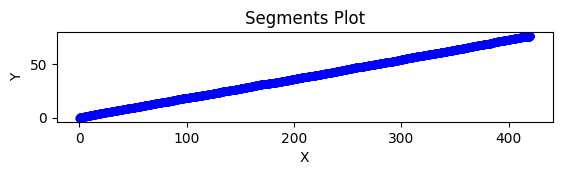

In [56]:
# After training, generate new fake data
# z = torch.randn(1, input_size_generator).unsqueeze(1).repeat(1, 855, 1).to(device)  # Generate random noise

# Evaulate the model after training and plot the generated data

# Set the models to evaluation mode

# Generate new data after training
# Set the models to evaluation mode
discriminator.eval()
generator.eval()

# Generate new data after training
with torch.no_grad():  # Disable gradient computation for inference
    z = torch.randn(1, input_size_generator).to(device)  # Generate random noise
    fake_data = generator(z)
    fake_data = fake_data.view(fake_data.size(0), 855, 2)

fake_data[:, :, 1] = denormalize_angles(fake_data[:, :, 1])

generated_data = []

for sample in fake_data:
    segment_data = []
    for vector in sample:
        segment_data.append({
            "length": vector[0].item(),
            "angleToNextVector": vector[1].item()
        })
    generated_data.append({"segments": segment_data})

print(generated_data)

def plot_segments_from_json(data):
    fig, ax = plt.subplots()
    
    for sample in data:
        print("sample", sample)
        segments = sample["segments"]
        x, y = 0, 0  # Starting point
        
        for segment in segments:
            length = segment["length"]
            tmpangle = segment["angleToNextVector"]
            #while tmpangle < 0:
            #    tmpangle = tmpangle + 360
            angle = np.radians(segment["angleToNextVector"])  # Convert angle to radians

            new_x = x + length * np.cos(angle)
            new_y = y + length * np.sin(angle) 
            segment["x"] = new_x
            segment["y"] = new_y
            
            # Plot a line segment from (x, y) to (new_x, new_y)
            ax.plot([x, new_x], [y, new_y], 'bo-', markersize=5)  # 'bo-' for blue line with circle markers

            # Update the current point
            x, y = new_x, new_y

    ax.set_aspect('equal', 'box')
    ax.autoscale()
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title('Segments Plot')
    plt.show()

# Example usage:
plot_segments_from_json(generated_data)

# Save the models




#read ground-1.json and plot the segment

# with open('../learning-data/ground-2.json', 'r') as f:
#     temp_ground_data = json.load(f)
#     temp_segments = temp_ground_data['segments']
#     plot_segments_from_json([{"segments": temp_segments}])



In [11]:
# Save trained discriminator and generator models
torch.save(discriminator.state_dict(), 'discriminator-1.pth')
torch.save(generator.state_dict(), 'generator-1.pth')

[{'segments': [{'length': 0.5000247359275818, 'angleToNextVector': 2.6814956665039062}, {'length': 0.49999335408210754, 'angleToNextVector': 2.9712295532226562}, {'length': 0.49998772144317627, 'angleToNextVector': 2.3513107299804688}, {'length': 0.5000283122062683, 'angleToNextVector': 1.8222274780273438}, {'length': 0.5000641345977783, 'angleToNextVector': 16.110748291015625}, {'length': 0.5000064969062805, 'angleToNextVector': 7.723014831542969}, {'length': 0.49996596574783325, 'angleToNextVector': 7.0804595947265625}, {'length': 0.49999287724494934, 'angleToNextVector': -9.486682891845703}, {'length': 0.5000056624412537, 'angleToNextVector': -2.619556427001953}, {'length': 0.5000308156013489, 'angleToNextVector': -16.29580307006836}, {'length': 0.4999552369117737, 'angleToNextVector': 36.913116455078125}, {'length': 0.500018835067749, 'angleToNextVector': 23.693634033203125}, {'length': 0.4999820590019226, 'angleToNextVector': -3.6005630493164062}, {'length': 0.4999299645423889, 'a

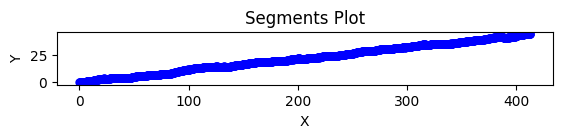

In [52]:
# load the generator and discriminator models from .pth files

#new_discriminator = FNNDiscriminator(input_size_discriminator, hidden_size_discriminator1, hidden_size_discriminator2, hidden_size_discriminator3, hidden_size_discriminator4, output_size_discriminator).to(device)
#new_generator = FNNGenerator(input_size_generator, hidden_size_generator1, hidden_size_generator2, hidden_size_generator3, hidden_size_generator4, hidden_size_generator5, hidden_size_generator6, hidden_size_generator7, output_size_generator).to(device)

new_discriminator = FNNDiscriminator(input_size_discriminator, hidden_sizes_discriminator, output_size_discriminator).to(device)
new_generator = FNNGenerator(input_size_generator, hidden_sizes_generator, output_size_generator).to(device)

new_discriminator.load_state_dict(torch.load('./testsaves/best_discriminator_test_1.pth'))
new_generator.load_state_dict(torch.load('./testsaves/best_generator_test_1.pth'))

# Generate new data after training
# z = torch.randn(1, input_size_generator).unsqueeze(1).repeat(1, 855, 1).to(device)  # Generate random noise
discriminator.eval()
generator.eval()

# Generate new data after training
with torch.no_grad():  # Disable gradient computation for inference
    z = torch.randn(1, input_size_generator).to(device)  # Generate random noise
    fake_data = generator(z)
    fake_data = fake_data.view(fake_data.size(0), 855, 2)

fake_data[:, :, 1] = denormalize_angles(fake_data[:, :, 1])

generated_data = []

for sample in fake_data:
    segment_data = []
    for vector in sample:
        segment_data.append({
            "length": vector[0].item(),
            "angleToNextVector": vector[1].item()
        })
    generated_data.append({"segments": segment_data})
    
print(generated_data)

# Example usage:
plot_segments_from_json(generated_data)

    
    